# Analysis of presence of variants by impact in lineages

## Setup

In [1]:
import os
os.getcwd()
os.chdir('/FastData/czirion/ServerDatabase/scripts')
import query_database as qdb
import pandas as pd
import duckdb
os.getcwd()

'/mnt/FastData/czirion/ServerDatabase/scripts'

In [2]:
mydb = '/FastData/czirion/Crypto_Desjardins/results_2024-10-22/02.Dataset/database.db'
# mydb = '/FastData/czirion/DiversityPipeline/results_joined_R1R2/02.Dataset/database.db'

## Number of samples per variant
Create the table `vars_presence_df` with `lineage, var_id, transcript_id, num_samples, percent_samples` columns.  
Remove the variants present in all the samples --> `vars_presence_df_filtered`.

Get number of total samples of each lineage

In [3]:
con = duckdb.connect(database=mydb, read_only=False)
query = "SELECT lineage,sample FROM samples"
result = con.execute(query).fetch_df()
con.close()
samples_per_lineage = result.groupby("lineage")['sample'].nunique().reset_index(name='total_samples')
samples_per_lineage

,lineage,total_samples
0,VNBI,122
1,VNBII,64
2,VNI,185
3,VNII,16


Get the variants that have HIGH, MODERATE and LOW impacts  
and which transcripts they are in.  

In [4]:
impact = "HIGH"

In [5]:
con = duckdb.connect(database=mydb, read_only=False)
query = f"""SELECT presence.lineage, presence.var_id, presence.sample,
                    effects.transcript_id
            FROM presence
            JOIN effects ON presence.var_id = effects.var_id
            WHERE effects.impact = '{impact}'
            """
vars_presence = con.execute(query).fetch_df()
con.close()

Get the number of samples that have each variant-transcript.  
And and what percentage of the samples of the lineage that corresponds to.

In [6]:
vars_presence_df = vars_presence.groupby(["lineage","var_id", "transcript_id"])['sample'].nunique().reset_index(name='num_samples')
vars_presence_df = vars_presence_df.merge(samples_per_lineage, on='lineage')
vars_presence_df['percent_samples'] = (vars_presence_df['num_samples'] / vars_presence_df['total_samples']) * 100
vars_presence_df['percent_samples'] = vars_presence_df['percent_samples'].round(2)
vars_presence_df = vars_presence_df.drop(columns=['total_samples'])

Number of total variants

In [7]:
vars_presence_df['var_id'].nunique()

11917

Number of variants present in only 1 sample

In [8]:
vars_unique_to_each_sample = vars_presence_df[vars_presence_df['num_samples'] == 1]
vars_unique_to_each_sample['var_id'].nunique()

4866

Filter out variants present in all the samples of each lineage.

In [9]:
vars_presence_df_filtered = vars_presence_df[vars_presence_df['percent_samples'] < 100]
vars_presence_df['var_id'].nunique() - vars_presence_df_filtered['var_id'].nunique()

170

In [10]:
vars_presence_df_filtered

,lineage,var_id,transcript_id,num_samples,percent_samples
0,VNBI,var_VNBI_100004,CNAG_01914-mR1,1,0.82
1,VNBI,var_VNBI_101030,CNAG_01901-mR1,31,25.41
2,VNBI,var_VNBI_101058,CNAG_01901-mR1,52,42.62
3,VNBI,var_VNBI_101109,CNAG_01900-mR1,1,0.82
4,VNBI,var_VNBI_101277,CNAG_01897-mR1,22,18.03
...,...,...,...,...,...
13792,VNII,var_VNII_89815,CNAG_07042-mR1,11,68.75
13793,VNII,var_VNII_9022,CNAG_00698-mR1,1,6.25
13794,VNII,var_VNII_908,CNAG_00080-mR1,12,75.00
13795,VNII,var_VNII_914,CNAG_00080-mR1,12,75.00


## Effects of variants with selected impact
Get the table of the effects and keep only the variants in `vars_presence_df_filtered` --> `effects_filtered`.

In [11]:
lineages = ("VNI", "VNII", "VNBI", "VNBII")
effects = qdb.effects(db = mydb, impact = (impact,), lineage = lineages)


        SELECT samples.dataset, samples.strain, presence.sample, presence.lineage,
            variants.var_id, chromosome_names.chromosome,
            variants.pos AS position, variants.ref AS reference, variants.alt AS alternative,
            effects.gene_name, effects.gene_id, effects.transcript_id,
            effects.impact, effects.effect_type, effects.effect,
            effects.codon_change, effects.amino_acid_change, effects.amino_acid_length,
            effects.transcript_biotype, effects.gene_coding, effects.exon_rank,
            mapq_depth.mean_depth_normalized, mapq_depth.mean_mapq
        FROM variants 
        JOIN chromosome_names ON variants.accession = chromosome_names.accession
        JOIN presence ON variants.var_id = presence.var_id
        JOIN effects ON variants.var_id = effects.var_id
        JOIN samples ON presence.sample = samples.sample
        LEFT JOIN mapq_depth ON mapq_depth.feature_id = effects.transcript_id AND mapq_depth.sample = presence.sampl

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [12]:
keep_columns = ['lineage', 'sample', 'var_id', 'transcript_id', 'gene_id', 'impact', 'mean_mapq', 'mean_depth_normalized']
effects = effects[keep_columns]

Filter out variants present in all samples of each lineage

In [13]:
effects_filtered = effects[effects['var_id'].isin(vars_presence_df_filtered['var_id'])]
effects_filtered['var_id'].nunique(), effects_filtered['transcript_id'].nunique()

(11747, 3841)

In [14]:
effects_filtered

,lineage,sample,var_id,transcript_id,gene_id,impact,mean_mapq,mean_depth_normalized
0,VNI,SRS417600,var_VNI_34353,CNAG_06802-mR1,CNAG_06802,HIGH,58.16,0.85
1,VNI,SRS417600,var_VNI_34349,CNAG_06802-mR1,CNAG_06802,HIGH,58.16,0.85
2,VNI,SRS417600,var_VNI_38434,CNAG_06719-mR1,CNAG_06719,HIGH,60.00,0.94
3,VNI,SRS417600,var_VNI_38433,CNAG_06719-mR1,CNAG_06719,HIGH,60.00,0.94
4,VNI,SRS417600,var_VNI_40329,CNAG_03635-mR1,CNAG_03635,HIGH,60.00,0.90
...,...,...,...,...,...,...,...,...
168717,VNII,SRS417641,var_VNII_34926,CNAG_03672-mR1,CNAG_03672,HIGH,60.00,0.73
168718,VNII,SRS417641,var_VNII_35190,CNAG_03650-mR1,CNAG_03650,HIGH,60.00,0.88
168719,VNII,SRS417641,var_VNII_34823,CNAG_03679-mR1,CNAG_03679,HIGH,60.00,0.94
168720,VNII,SRS417641,var_VNII_34823,CNAG_03679-mR2,CNAG_03679,HIGH,60.00,0.94


## Number of variants per transcript per sample
Get the number of variants present in each transcript per sample --> `num_vars`

In [33]:
num_vars = effects_filtered.groupby(["lineage", "sample", "transcript_id", "mean_mapq", "mean_depth_normalized"])['var_id'].nunique().reset_index(name='num_vars')
num_vars

,lineage,sample,transcript_id,mean_mapq,mean_depth_normalized,num_vars
0,VNBI,SRS404469,CNAG_00014-mR1,50.15,0.94,1
1,VNBI,SRS404469,CNAG_00017-mR1,60.00,0.84,1
2,VNBI,SRS404469,CNAG_00018-mR1,59.99,0.78,1
3,VNBI,SRS404469,CNAG_00039-mR1,58.37,0.94,1
4,VNBI,SRS404469,CNAG_00080-mR1,60.00,1.01,2
...,...,...,...,...,...,...
123053,VNII,SRS881212,CNAG_07963-mR1,60.00,0.77,1
123054,VNII,SRS881212,CNAG_07973-mR1,60.00,0.87,1
123055,VNII,SRS881212,CNAG_07973-mR2,60.00,0.87,1
123056,VNII,SRS881212,CNAG_07975-mR1,60.00,0.86,1


## Reference genes annotation

In [19]:
con = duckdb.connect(database=mydb, read_only=False)
query = f"""SELECT lineage, gene_id, feature_id, repeat_fraction
            FROM gff
            WHERE lineage IN {lineages} and primary_tag = 'mRNA'
            """
ref_genes = con.execute(query).fetch_df()
con.close()

In [22]:
con = duckdb.connect(database=mydb, read_only=False)
query = f"""SELECT lineage, sample
            FROM samples
            WHERE lineage IN {lineages}
            """
samples = con.execute(query).fetch_df()
con.close()

In [26]:
annotation = ref_genes.merge(samples, on='lineage')
annotation = annotation.rename(columns={'feature_id': 'transcript_id'})


In [85]:
effects_annotation = annotation.merge(effects_filtered, on=['lineage', 'sample', 'gene_id','transcript_id'], how = "left")

In [86]:
effects_annotation.loc[effects_annotation['impact'].isna(), 'repeat_fraction'] = float('nan')
effects_annotation

,lineage,gene_id,transcript_id,repeat_fraction,sample,var_id,impact,mean_mapq,mean_depth_normalized
0,VNBII,CNAG_06942,CNAG_06942-mR1,NaN,SRS881161,NaN,NaN,NaN,NaN
1,VNBII,CNAG_06942,CNAG_06942-mR1,NaN,SRS881185,NaN,NaN,NaN,NaN
2,VNBII,CNAG_06942,CNAG_06942-mR1,NaN,SRS885171,NaN,NaN,NaN,NaN
3,VNBII,CNAG_06942,CNAG_06942-mR1,NaN,SRS881205,NaN,NaN,NaN,NaN
4,VNBII,CNAG_06942,CNAG_06942-mR1,NaN,SRS881216,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3036814,VNII,CNAG_07618,CNAG_07618-mR1,NaN,SRS417641,NaN,NaN,NaN,NaN
3036815,VNII,CNAG_07618,CNAG_07618-mR1,NaN,SRS417678,NaN,NaN,NaN,NaN
3036816,VNII,CNAG_07618,CNAG_07618-mR1,NaN,SRS520177,NaN,NaN,NaN,NaN
3036817,VNII,CNAG_07618,CNAG_07618-mR1,NaN,SRS520179,NaN,NaN,NaN,NaN


In [87]:
effects_annotation['status'] = effects_annotation['impact'].apply(lambda x: "No variant" if pd.isna(x) else "variant")

In [88]:
effects_annotation.loc[
    (pd.notna(effects_annotation['mean_mapq']) & (effects_annotation['mean_mapq'] < 20)) |
    (pd.notna(effects_annotation['mean_depth_normalized']) & ((effects_annotation['mean_depth_normalized'] < 0.5) | (effects_annotation['mean_depth_normalized'] > 1.5))) |
    (pd.notna(effects_annotation['repeat_fraction']) & (effects_annotation['repeat_fraction'] > 0.5)), 
    'status'
] = "Filtered"

In [93]:
effects_annotation.loc[effects_annotation['status'] == 'Filtered', 'var_id'] = float('nan')

In [98]:
effects_annotation_filtered = effects_annotation.groupby(["lineage", "sample", "gene_id"])['var_id'].nunique(dropna=True).reset_index(name='num_vars')

In [99]:
effects_annotation_filtered

,lineage,sample,gene_id,num_vars
0,VNBI,SRS404469,CNAG_00001,0
1,VNBI,SRS404469,CNAG_00006,0
2,VNBI,SRS404469,CNAG_00007,0
3,VNBI,SRS404469,CNAG_00008,0
4,VNBI,SRS404469,CNAG_00009,0
...,...,...,...,...
2677521,VNII,SRS881212,CNAG_08025,0
2677522,VNII,SRS881212,CNAG_08026,0
2677523,VNII,SRS881212,CNAG_08027,0
2677524,VNII,SRS881212,CNAG_08028,0


In [102]:
effects_annotation_filtered['presence_vars'] = effects_annotation_filtered['num_vars'].apply(lambda x: 0 if x == 0 else 1)

In [ ]:
effects_annotation_filtered

## Write the filtered effects table to file

In [33]:
vars_per_gene.to_csv('/FastData/czirion/Crypto_Desjardins/fungal_pop/data/presence_variants.csv', index=False)

# Extra
Plot the relationship between the number of variants, MAPQ, Depth and fraction of repetitive sequences

### Complete dataset

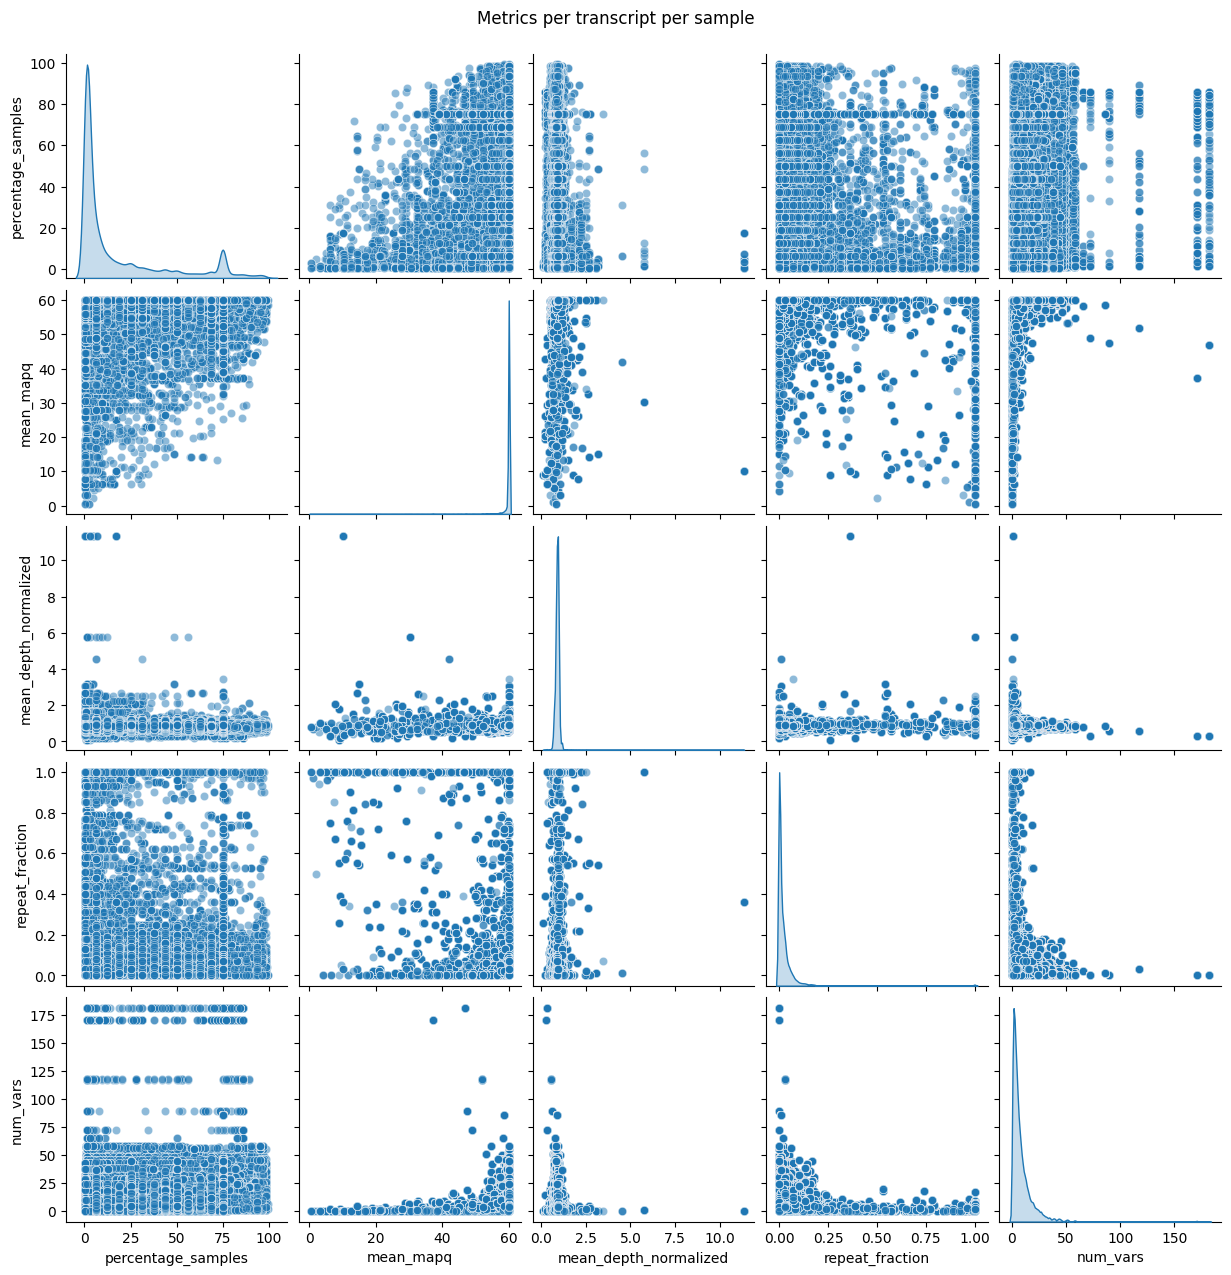

In [34]:
import seaborn as sns

import matplotlib.pyplot as plt

columns_of_interest = ['percentage_samples', 'mean_mapq', 'mean_depth_normalized', 'repeat_fraction', 'num_vars']

sns.pairplot(vars_presence_quality[columns_of_interest], diag_kind='kde', plot_kws={'alpha':0.5})
plt.suptitle('Metrics per transcript per sample', y=1.02)
plt.show()

### Filtered dataset

Filter out transcripts with MAPQ < 50, Depth < 4, fraction of repetitive sequences > 0.5

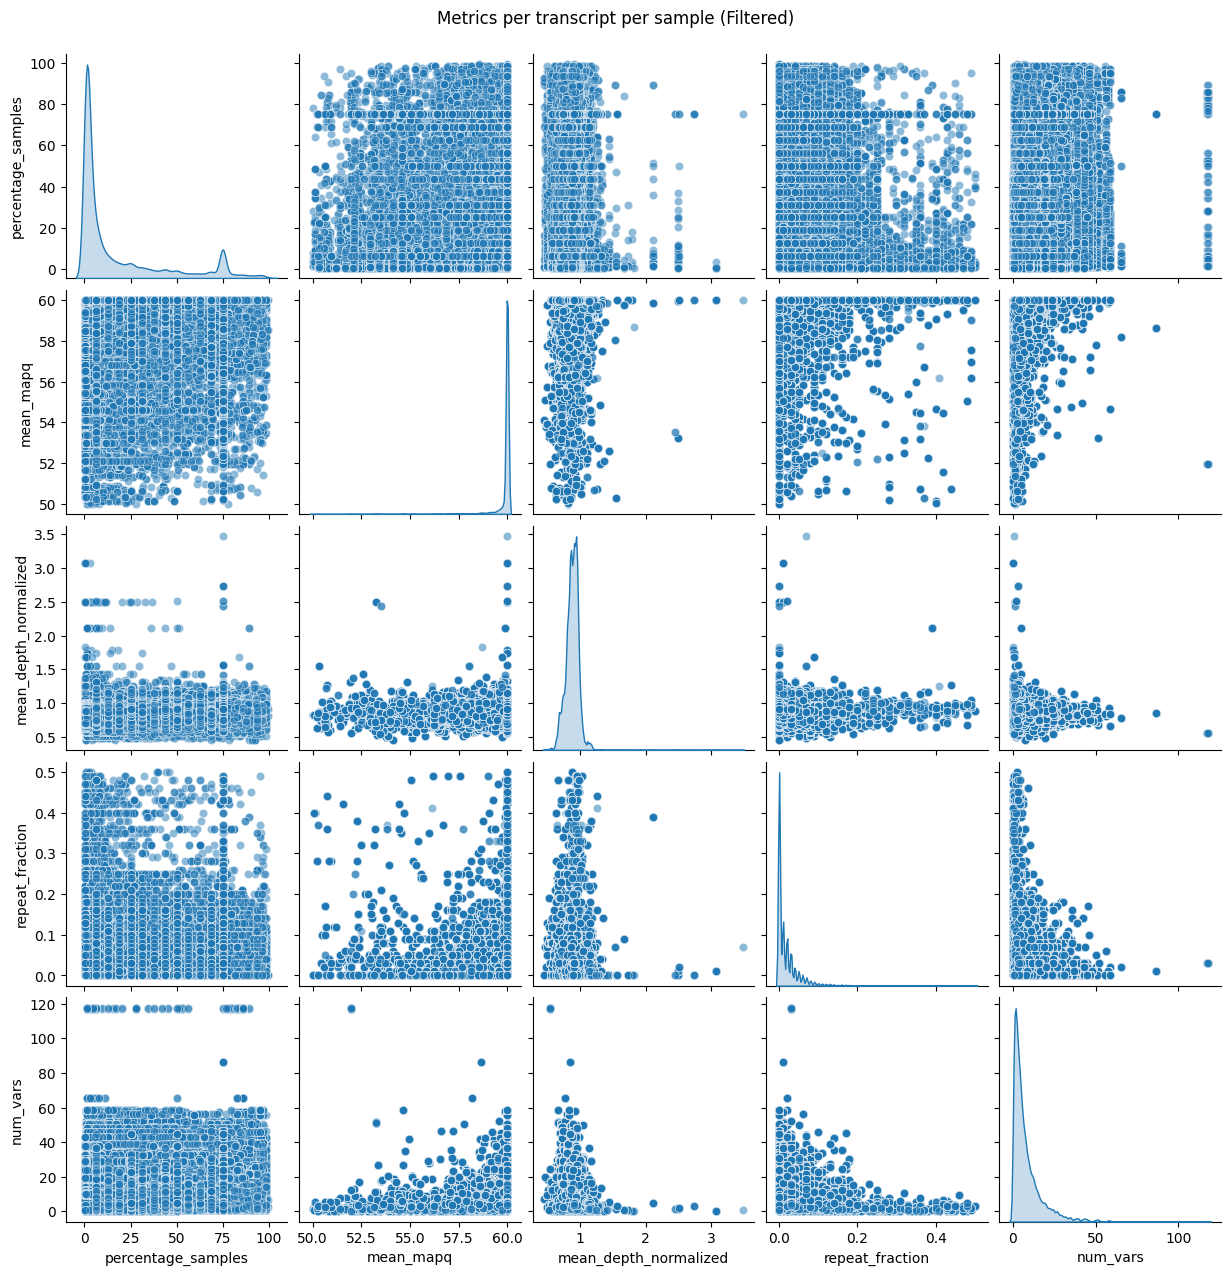

In [65]:
columns_of_interest = ['percentage_samples', 'mean_mapq', 'mean_depth_normalized', 'repeat_fraction', 'num_vars']

sns.pairplot(vars_presence_quality_filtered[columns_of_interest], diag_kind='kde', plot_kws={'alpha':0.5})
plt.suptitle('Metrics per transcript per sample (Filtered)', y=1.02)
plt.show()

In [60]:
gene_stats = quality_sample.groupby(['lineage', 'transcript_id']).agg({
    'mean_mapq': ['mean', 'std']
}).reset_index()

# Flatten the MultiIndex columns
gene_stats.columns = ['lineage', 'transcript_id', 'mean_mapq_mean', 'mean_mapq_std']
gene_stats

,lineage,transcript_id,mean_mapq_mean,mean_mapq_std
0,VNBI,CNAG_00001-mR1,26.128197,9.412994
1,VNBI,CNAG_00006-mR1,58.328852,4.455996
2,VNBI,CNAG_00007-mR1,59.999754,0.002018
3,VNBI,CNAG_00008-mR1,59.999426,0.002666
4,VNBI,CNAG_00009-mR1,59.999672,0.001788
...,...,...,...,...
30874,VNII,CNAG_08026-mR1,56.523750,1.813629
30875,VNII,CNAG_08027-mR1,60.000000,0.000000
30876,VNII,CNAG_08028-mR1,59.999375,0.002500
30877,VNII,CNAG_08028-mR2,59.999375,0.002500
